# Predicting Linkedin Summary Topic Using LDA

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

import re, nltk, spacy

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import bigfloat
bigfloat.exp(5000,bigfloat.precision(100))

BigFloat.exact('2.9676283840236670689662968052896e+2171', precision=100)

In [2]:
dataLinkedin = pd.read_csv('Datasets/datascientist.csv', error_bad_lines=False);

#Remove the first column
del dataLinkedin['Unnamed: 0'];

# We only need the summary text column from the data
linkedinSummary = dataLinkedin[['summary']];

In [3]:
#Remove NaNs
linkedinSummary.dropna(how='any', inplace=True)
linkedinSummary = linkedinSummary.astype('str');

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [4]:
#Remove unknown characters

import string
linkedinSummary = linkedinSummary.replace(r'\n',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'►',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'✔',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\t',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\-',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\'',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\"',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\/',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\:',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\•',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\...',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\... ',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\!',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\,',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\.',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\(',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\)',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\|',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\+',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\@',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\_',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\;',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\>',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\<',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'I',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'http',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'www',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'datum',' ', regex=True)

In [5]:
linkedinSummarytwo = linkedinSummary.summary.values.tolist()
print(linkedinSummarytwo)

['Ambitious  driven  intelligent  steely  efficient  resourceful  critical  savvy  unrelenting Thinker  doer         realist  idealist  willing  able  can do  will do   ', 'Proactive  self motivated  and results driven data scientist who thrives in intellectually challenging positions xcels at establishing positive working relationships with stakeholders and leading technical teams from business concept through deployment of analytical solution ecognized for thought leadership and superior problem solving skills on projects that require creative  interdisciplinary solutions    ', '  have been learning and working in analytics since 2012 here are many reasons why   love this field he main reason is that   like to work on problems that are interesting and not trivial  do not have a specific list of languages and software that must fit with me  just enjoy the opportunity of working on complex data problems and trying to find a solution for them re is a list of data science topics and soft

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

linkedinSum = list(sent_to_words(linkedinSummarytwo))
print(linkedinSum)

[['ambitious', 'driven', 'intelligent', 'steely', 'efficient', 'resourceful', 'critical', 'savvy', 'unrelenting', 'thinker', 'doer', 'realist', 'idealist', 'willing', 'able', 'can', 'do', 'will', 'do'], ['proactive', 'self', 'motivated', 'and', 'results', 'driven', 'data', 'scientist', 'who', 'thrives', 'in', 'intellectually', 'challenging', 'positions', 'xcels', 'at', 'establishing', 'positive', 'working', 'relationships', 'with', 'stakeholders', 'and', 'leading', 'technical', 'teams', 'from', 'business', 'concept', 'through', 'deployment', 'of', 'analytical', 'solution', 'ecognized', 'for', 'thought', 'leadership', 'and', 'superior', 'problem', 'solving', 'skills', 'on', 'projects', 'that', 'require', 'creative', 'solutions'], ['have', 'been', 'learning', 'and', 'working', 'in', 'analytics', 'since', 'here', 'are', 'many', 'reasons', 'why', 'love', 'this', 'field', 'he', 'main', 'reason', 'is', 'that', 'like', 'to', 'work', 'on', 'problems', 'that', 'are', 'interesting', 'and', 'not'

In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(linkedinSum, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[linkedinSum], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[linkedinSum[0]]])

/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['ambitious', 'driven', 'intelligent', 'steely', 'efficient', 'resourceful', 'critical', 'savvy', 'unrelenting', 'thinker', 'doer', 'realist', 'idealist', 'willing', 'able', 'can', 'do', 'will', 'do']


In [9]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(linkedinSum, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


print(data_lemmatized[:2])

['ambitious drive intelligent steely efficient resourceful critical savvy unrelenting thinker doer realist idealist willing able can do will do', 'proactive self motivated result drive datum scientist who thrive intellectually challenge position xcel establish positive working relationship stakeholder lead technical team business concept deployment analytical solution ecogniz thought leadership superior problem solve skill project that require creative solution']


In [70]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=2,                        # minimum reqd occurences of a word
                             max_df=30,
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [71]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  1.319576060343045 %


In [92]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_topics=3,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=60,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=60, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=3, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


In [93]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -78431.88024201567
Perplexity:  1467.3907092692975
{'batch_size': 60,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'n_topics': 3,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [94]:
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_components': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [75]:
GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_topics': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_topics': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [57]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 10}
Best Log Likelihood Score:  -34856.87434663943
Model Perplexity:  1852.354676041477


In [58]:
# Compute Perplexity
#print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

NameError: name 'id2word' is not defined

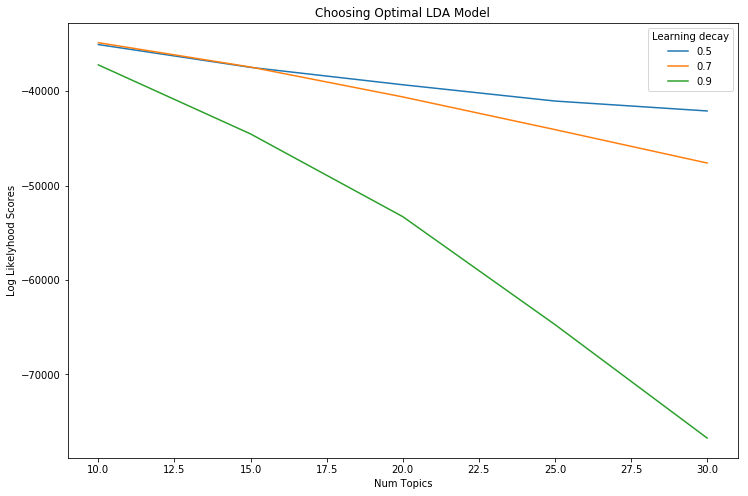

In [59]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [10, 15, 20, 25, 30]
log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.5]
log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.7]
log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [95]:
# Create Document - Topic Matrix
lda_output = lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_topics)]

# index names
docnames = ["Doc" + str(i) for i in range(len(linkedinSum))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

TypeError: 'NoneType' object cannot be interpreted as an integer

In [96]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

NameError: name 'df_document_topic' is not defined

In [97]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
1      41.549871        1       1 -372.142456 -195.243271
0      36.102580        1       2 -437.769562 -443.703552
2      22.347549        1       3 -620.127258 -262.638367, topic_info=     Category       Freq            Term      Total  loglift  logprob
term                                                                 
1017  Default  27.000000           numpy  27.000000  30.0000  30.0000
961   Default  26.000000           mysql  26.000000  29.0000  29.0000
276   Default  30.000000         company  30.000000  28.0000  28.0000
1407  Default  29.000000          social  29.000000  27.0000  27.0000
1507  Default  24.000000             svm  24.000000  26.0000  26.0000
173   Default  23.000000           boost  23.000000  25.0000  25.0000
232   Default  33.000000  classification  33.000000  24.0000  24.0000
551   Default  14.000000         extract  14.000000  23.0000  23.0000
1103  Default  21.000000             phd  21.000000  22.0000  22.0000
1377  Default  23.000000          server  23.000000  21.0000  21.0000
685   Default  13.000000         history  13.000000  20.0000  20.0000
1530  Default  20.000000      tensorflow  20.000000  19.0000  19.0000
1414  Default  16.000000          source  16.000000  18.0000  18.0000
962   Default  20.000000           naive  20.000000  17.0000  17.0000
1245  Default  13.000000          record  13.000000  16.0000  16.0000
1309  Default  23.000000            role  23.000000  15.0000  15.0000
1360  Default  12.000000        security  12.000000  14.0000  14.0000
144   Default  19.000000            baye  19.000000  13.0000  13.0000
934   Default  19.000000         mongodb  19.000000  12.0000  12.0000
871   Default  18.000000       mapreduce  18.000000  11.0000  11.0000
908   Default  18.000000     methodology  18.000000  10.0000  10.0000
884   Default  18.000000      matplotlib  18.000000   9.0000   9.0000
793   Default  15.000000            kill  15.000000   8.0000   8.0000
369   Default  20.000000         dataset  20.000000   7.0000   7.0000
29    Default  11.000000        activity  11.000000   6.0000   6.0000
1276  Default  11.000000      researcher  11.000000   5.0000   5.0000
536   Default  20.000000     experienced  20.000000   4.0000   4.0000
389   Default  14.000000     demonstrate  14.000000   3.0000   3.0000
634   Default  17.000000          ggplot  17.000000   2.0000   2.0000
93    Default  20.000000            area  20.000000   1.0000   1.0000
...       ...        ...             ...        ...      ...      ...
1679   Topic3   3.630264        xperienc   4.242176   1.3427  -6.4956
827    Topic3   3.391030            list   3.976956   1.3391  -6.5637
1607   Topic3   4.723677          useful   5.541562   1.3388  -6.2323
1414   Topic3  13.677375          source  16.551622   1.3077  -5.1691
389    Topic3  11.614759     demonstrate  14.322823   1.2889  -5.3326
793    Topic3  11.995829            kill  15.177603   1.2632  -5.3003
1081   Topic3  10.417865         pattern  13.670050   1.2268  -5.4413
1103   Topic3  15.101373             phd  21.032579   1.1672  -5.0701
1085   Topic3   5.154793       pecialtie   6.166936   1.3192  -6.1449
369    Topic3  14.021889         dataset  20.250560   1.1309  -5.1442
1362   Topic3  10.255323            seek  13.979388   1.1887  -5.4571
446    Topic3   7.726410         dynamic  10.114154   1.2292  -5.7402
536    Topic3  13.862084     experienced  20.859942   1.0898  -5.1557
404    Topic3   9.420137       developer  13.014913   1.1752  -5.5420
93     Topic3  13.174933            area  20.303658   1.0660  -5.2065
638    Topic3  11.562975          global  17.446537   1.0871  -5.3371
28     Topic3  11.262945        actively  17.361498   1.0657  -5.3633
726    Topic3   9.103713     information  12.755033   1.1612  -5.5762
1395   Topic3  10.923009      simulation  17.674311   1.0172  -5.3940
1540   Topic3  10.355524   

In [98]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

NameError: name 'topicnames' is not defined

In [99]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=10):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19
Topic 0,classification,numpy,mysql,series,svm,boost,server,processing,tensorflow,natural,mean,naive,support,expertise,mongodb,baye,testing,methodology,platform,mapreduce
Topic 1,company,social,role,career,result,people,currently,quantitative,client,advanced,intelligence,program,environment,look,high,enjoy,operation,economic,believe,startup
Topic 2,phd,analyze,dataset,extract,experienced,source,area,history,record,kill,security,demonstrate,global,actively,activity,simulation,end,researcher,pattern,theory


In [144]:
# Define function to predict topic for a given text document.
nlp = spacy.load('en', disable=['parser', 'ner'])

def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)

    # Step 4: LDA Transform
    topic_probability_scores = lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

# Predict the topic

googleDatasci = pd.read_csv('Datasets/googledatasci.csv');
googleSummary = googleDatasci[['summary']]

googleSummary.dropna(how='any', inplace=True)
googleSummary = googleSummary.astype('str');

googleSummary = googleSummary.replace(r'\n',' ', regex=True)
googleSummary = googleSummary.replace(r'►',' ', regex=True)
googleSummary = googleSummary.replace(r'✔',' ', regex=True)
googleSummary = googleSummary.replace(r'\t',' ', regex=True)
googleSummary = googleSummary.replace(r'\-',' ', regex=True)
googleSummary = googleSummary.replace(r'\'',' ', regex=True)
googleSummary = googleSummary.replace(r'\"',' ', regex=True)
googleSummary = googleSummary.replace(r'\/',' ', regex=True)
googleSummary = googleSummary.replace(r'\:',' ', regex=True)
googleSummary = googleSummary.replace(r'\•',' ', regex=True)
googleSummary = googleSummary.replace(r'\...',' ', regex=True)
googleSummary = googleSummary.replace(r'\... ',' ', regex=True)
googleSummary = googleSummary.replace(r'\!',' ', regex=True)
googleSummary = googleSummary.replace(r'\,',' ', regex=True)
googleSummary = googleSummary.replace(r'\.',' ', regex=True)
googleSummary = googleSummary.replace(r'\(',' ', regex=True)
googleSummary = googleSummary.replace(r'\)',' ', regex=True)
googleSummary = googleSummary.replace(r'\|',' ', regex=True)
googleSummary = googleSummary.replace(r'\+',' ', regex=True)
googleSummary = googleSummary.replace(r'\@',' ', regex=True)
googleSummary = googleSummary.replace(r'\_',' ', regex=True)
googleSummary = googleSummary.replace(r'\;',' ', regex=True)
googleSummary = googleSummary.replace(r'\>',' ', regex=True)
googleSummary = googleSummary.replace(r'\<',' ', regex=True)


mytext = ["Experienced data scientist with a passion for NLP and telling a story"]

googlesum = [googleSummary['summary'][2]]

topic, prob_scores = predict_topic(text = googlesum)
print(prob_scores)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[[0.3894543  0.36196004 0.24858566]]


In [145]:
[googleSummary['summary'][2]]

['Strong Analytical Skills  Hands on experience in handling large & complex data sets  Online Industry Expertise  In Depth Product Knowledge  Search  Mobile Display & YouTube   Collaboration and        Sales Account Management Skills   ']

In [101]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.31  0.91  0.29]
 [ 0.89 -0.38  0.24]]
Perc of Variance Explained: 
 [0.14 0.49]


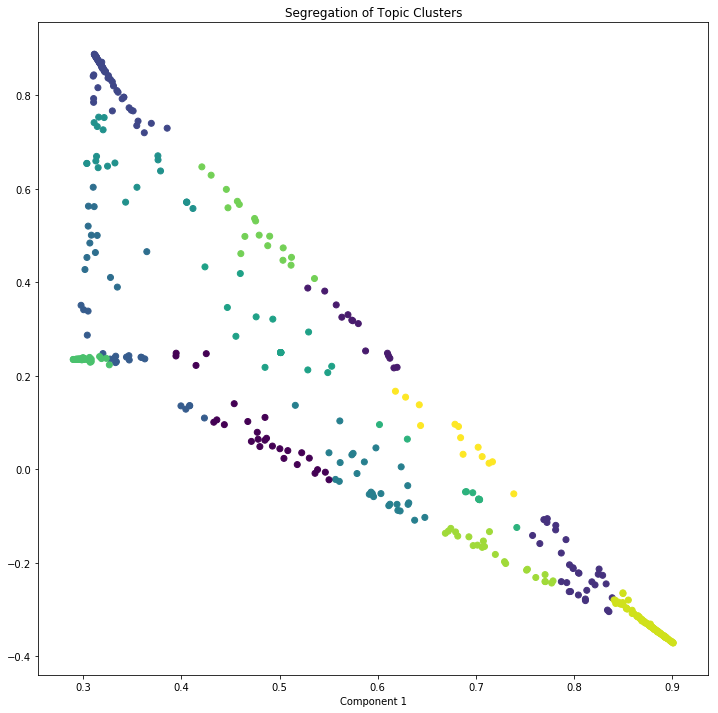

In [102]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

In [103]:
from sklearn.metrics.pairwise import euclidean_distances

nlp = spacy.load('en', disable=['parser', 'ner'])

def similar_documents(text, doc_topic_probs, documents = linkedinSum, nlp=nlp, top_n=5, verbose=False):
    topic, x  = predict_topic(text)
    dists = euclidean_distances(x.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dists)[:top_n]
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

In [128]:
# Get similar documents
mytext = ["ability to communicate results effectively."]

jobDescription = pd.read_csv('jobdescription.csv');

jobtext = [jobDescription.JobDescription[0]];

doc_ids, docs = similar_documents(text=jobtext, doc_topic_probs=lda_output, documents = linkedinSum, top_n=1, verbose=True)
print('\n', docs[0][:500])

Topic KeyWords:  ['company', 'social', 'role', 'career', 'result', 'people', 'currently', 'quantitative', 'client', 'advanced', 'intelligence', 'program', 'environment', 'look', 'high', 'enjoy', 'operation', 'economic', 'believe', 'startup']
Topic Prob Scores of text:  [[0.1 0.6 0.3]]
Most Similar Doc's Probs:   [[0.  0.7 0.3]]

 ['data', 'scientist', 'with', 'physics', 'phd', 'nterested', 'in', 'using', 'my', 'passion', 'skillset', 'research', 'and', 'learning', 'abilities', 'to', 'shed', 'light', 'and', 'tackle', 'important', 'problems', 'killed', 'in', 'customer', 'segmentation', 'topic', 'modeling', 'nlp', 'and', 'exploratory', 'data', 'analysis', 'and', 'visualization']


In [129]:
jobtext

['As every CMO knows, employing technology, data and analytics to business challenges is the cost of entry, not a nice to have. Unlocking the value of consumer data can deliver growth, revenue and ROI, and create differentiation to stay on top. Real-time action is instrumental in driving results within a highly fragmented marketplace. AnnalectÕs data solutions are built to deliver insightful results with speed, accuracy and a single version of the truth. In leveraging the DNA of a marketing agency with a talent pool of developers, data scientists and Ph.Ds, we hold a unique position in the increasingly crowded ad tech and consulting space. Join our dynamic and diverse team at Annalect Ð data solutions for marketers, by marketers. Exploration and experimentation with large number of datasets to draw insights and search for stories. Modeling and building algorithms on top of our vast number of datasets. Assist in designing tech infrastructure and data pipelines (ETL, data automation, dat